In [64]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.insert(0, '../')

# import embedding methods
from embedding.bernoulli import Bernoulli
from embedding.kl import KL
from embedding.matrix_factorization import MatrixFactorization

# import evaluation methods
from evaluation import evaluate_link_prediction
from evaluation import evaluate_node_classification
from evaluation import evaluate_node_clustering
# 
# import utils
from utils import graph_util
from utils import plot_util
from utils import model_util

# visualization
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment 1

The results of the current experiment are stored at experiments/results/2020_01_15_20_03
adjacency
	Node clustering evaluation has started...
Epoch    0, loss = 0.64615
Model evaluation took: 1.1719484329223633 seconds
adjacency
	Node clustering evaluation has started...
Epoch    0, loss = 2.23947
Model evaluation took: 7.363898277282715 seconds
adjacency
	Node clustering evaluation has started...
Epoch    0, loss = 0.40750
Model evaluation took: 1.1113739013671875 seconds
ppr
	Node clustering evaluation has started...
Epoch    0, loss = 48109016.00000
Model evaluation took: 2.534106969833374 seconds
sum_power_tran
	Node clustering evaluation has started...
Epoch    0, loss = 149553102848.00000
Model evaluation took: 23.92396593093872 seconds
sum_power_tran
	Node clustering evaluation has started...
Epoch    0, loss = 149554053120.00000
Model evaluation took: 23.93302273750305 seconds
transition
	Node clustering evaluation has started...
Epoch    0, loss = 48137864.00000
Model evaluati

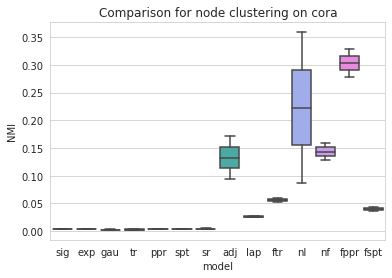

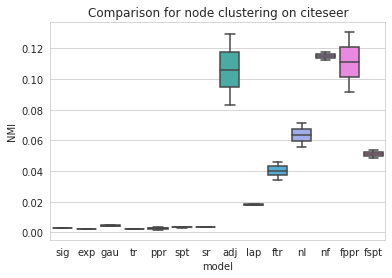

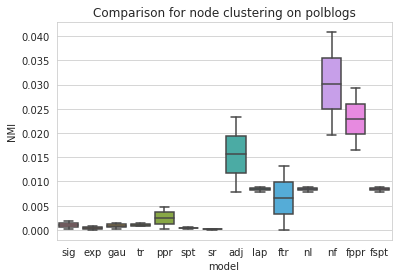

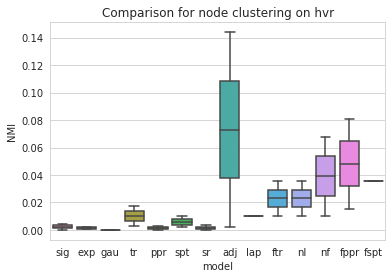

In [65]:
# Experiment 1

exp = {
    "max_epochs": 1,
    "learning_rate": 1e-2, #Adam
    "weight_decay": 1e-7,
    
    "link_prediction": False,
    "link_pred_num_rounds": 1,
    "link_pred_train_ratio": 0.8,
    "link_pred_eval_every_n_steps": 5,
    "link_pred_edge_emb_method": "average",
    
    "node_classification": False,
    "node_class_num_rounds": 2,
    "node_class_train_ratio": 0.8,
    "node_class_eval_every_n_steps": 5,
    
    "node_clustering": True,
    "node_clustering_num_rounds": 2,
    "node_clustering_eval_epochs": 1,
}

# pick datasets
#datasets = ["cora", "citeseer", "polblogs"] # parliament, hvr, purdue_facebook
#datasets = ["cora", "hvr", "polblogs"] 
datasets = ["cora", "citeseer", "polblogs","hvr"] 

#TO DO:
#Laplacian (nobrainer) : Till done
#NetMF : Tillcd
#PPR : Till done(?)
#Sum_Power_Tran : Jan
#Sim_Rank : Jan
#Big Task: what to do with W / U Epsilon : Jan
#possible: Forest Fire / Stochastic Optimization


#Bernoulli
model_01 = Bernoulli(embedding_dimension=64, decoder='sigmoid') #works!
#model_02 = Bernoulli, sigmoid with W 
model_03 = Bernoulli(embedding_dimension=64, decoder='gaussian') #works!
model_04 = Bernoulli(embedding_dimension=64, decoder='exponential') #works!
#model_05 = Bernoulli, exponential with W


#KL
#KL(similarity_measure{needs to be row stochastic}|softmax(ZZ^T))
model_06 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='ppr')
model_07 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sum_power_tran')
model_08 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sim_rank')
model_09 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='transition')
#model_10 = KL, PPR, with W
#model_11 = KL, Sum_Power_Tran, with W
#model_12 = KL, Sim_Rank, with W
#model_13 = KL, Transition, with W


#Matrix Factorization
model_14 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency') #works!
model_15 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian') 
model_16 = MatrixFactorization(embedding_dimension=64, similarity_measure='transition')
model_17 = MatrixFactorization(embedding_dimension=64, similarity_measure='sym_normalized_laplacian') #works!
model_18 = MatrixFactorization(embedding_dimension=64, similarity_measure='NetMF')
model_19 = MatrixFactorization(embedding_dimension=64, similarity_measure='ppr')
model_20 = MatrixFactorization(embedding_dimension=64, similarity_measure='sum_power_tran')
model_21 = MatrixFactorization(embedding_dimension=64, similarity_measure='sim_rank')
#model_22 = MF, adjacency, with W
#model_23 = MF, laplacian, with W
#model_24 = MF, Transition, with W
#model_25 = MF, sym_normalized_laplacian, with W
#model_26 = MF, NetMF, with W
#model_27 = MF, PPR, with W
#model_28 = MF, Sum_Power_Tran, with W
#model_29 = MF, Sim_Rank, with W

# model_14, model_15, model_16, 
embedding_methods = [model_01, model_03, model_04,
                     model_06, model_07,model_07,model_09,
                     model_14,model_15,model_16,model_17,model_18,model_19,model_20
                    ]

#embedding_methods = [model_20]
#embedding_methods = [model_15]

# Normalized mutual information

dset_NMI=[]
# setup folders to store experiment setup summary and results
result_folder = plot_util.setup_folders_and_summary_files(exp, datasets, embedding_methods)
print(f'The results of the current experiment are stored at experiments/{result_folder}')

for dataset in datasets:
    total_NMI=[]
    # load dataset
    A, y = graph_util.load_dataset(dataset)
    
    
    
    for model in embedding_methods:
        print(model._similarity_measure)
        start = time.time()
        # do link prediction
        if(exp["link_prediction"]):
            link_prediction_folder = result_folder + "/link_prediction"
            evaluate_link_prediction.expLP(A,dataset,model,exp["link_pred_num_rounds"],
                                           link_prediction_folder, train_ratio=exp["link_pred_train_ratio"], 
                                           edge_emb_method=exp["link_pred_edge_emb_method"],train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["link_pred_eval_every_n_steps"], undirected=True)
            
        # do node classification
        if(exp["node_classification"]):
            node_classification_folder = result_folder + "/node_classification"
            evaluate_node_classification.expNC(A,y,dataset,model, exp["node_class_num_rounds"],
                                               node_classification_folder, train_ratio=exp["node_class_train_ratio"],
                                               train_epochs=exp["max_epochs"],eval_epochs=exp["node_class_eval_every_n_steps"],undirected=True)
        if(exp["node_clustering"]):
            node_clustering_folder = result_folder + "/node_clustering"
            NMI = evaluate_node_clustering.exp_Node_Clustering(A,y,dataset,model,exp["node_clustering_num_rounds"],
                                           node_clustering_folder , train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["node_clustering_eval_epochs"],undirected=True)
            total_NMI.append(NMI)
        end = time.time()
        print(f'Model evaluation took: {end-start} seconds')
    dset_NMI.append(total_NMI)
    
    
headers= ['sig','exp','gau',
            'tr','ppr','spt','sr',
            'adj','lap','ftr','nl','nf', 'fppr', 'fspt'
         ]
for ds,NMI in zip(datasets,dset_NMI):
    plt.figure()
    sns_plot = sns.boxplot(x=headers, y=NMI);
    plt.title("Comparison for node clustering on "+ds)
    plt.xlabel("model")
    plt.ylabel("NMI")
    sns_plot.figure.savefig('plots/NMI_'+ds+'.png')

    with open('results_vis/'+ds+'NMI_results.txt','w') as f:
        for listitem in NMI:
            f.write('%s\n' % listitem)